In [1]:
# Import packages and set configuration
# from IPython.display import display

%load_ext autoreload
%autoreload 2

In [2]:
tickers = ["BTCUSDT", "ETHUSDT", "BNBUSDT", "SOLUSDT", "XRPUSDT", "ADAUSDT", "AVAXUSDT", "DOGEUSDT", "TRXUSDT",
           "DOTUSDT", "LINKUSDT", "SHIBUSDT", "LTCUSDT", "BCHUSDT", "UNIUSDT"]
interval = "1h"

fee_rate = 0.0005  # 0.05%
initial_cash = 100000
position_size = 0.2  # each of 5 pairs has 20% of portfolio capital

beta_hedge = True
is_spread = False

### 1. Training

In [3]:
pair_selection_start = "2024-01-01"
pair_selection_end = "2024-03-01"

#### 1.1 Pair Selection

In [4]:
# Load data
from modules.data_services.data_loaders import load_data

df = load_data(
    tickers=tickers,
    start=pair_selection_start,
    end=pair_selection_end,
    interval=interval
)

In [5]:
# Pair Selection (select a TOP5 pairs)
from modules.pair_selection.statistical_tests import engle_granger_cointegration

eg_df = engle_granger_cointegration(df)
tickers = eg_df.iloc[0:5, 0].tolist()
eg_df.head(5)

,pair,eg_p_value,adf_stat
0,ETHUSDT-BCHUSDT,0.002988,-4.256718
1,BTCUSDT-BCHUSDT,0.004171,-4.161398
2,BNBUSDT-UNIUSDT,0.007593,-3.982967
3,BTCUSDT-ADAUSDT,0.013955,-3.790522
4,BTCUSDT-SOLUSDT,0.015325,-3.759751


#### 1.2 Parameter optimization

In [6]:
pre_training_start = "2024-01-01"
training_start = "2024-02-01"
training_end = "2024-03-01"

In [7]:
# Perform Bayesian Optimization
from skopt.space import Integer, Real
from modules.performance.strategy import calc_bayesian_params

param_space = [
    Integer(2, 600, name="rolling_window"),
    Real(1.0, 5.0, name="entry_threshold"),
    Real(0.0, 3.0, name="exit_threshold"),
    Real(1.0, 3.0, name="stop_loss"),
]
metric = ("sortino_ratio_annual", "0.05% fee")
minimize = False # Maximize metric

best_params, best_score = calc_bayesian_params(ticker_x, ticker_y, fee_rate, initial_cash, position_size, pre_training_start, training_start, training_end, interval, beta_hedge, is_spread, param_space, metric, minimize)

print(best_params)
print(best_score)

{'rolling_window': np.int64(2), 'entry_threshold': 1.1252259559107407, 'exit_threshold': 0.8156205643958556, 'stop_loss': 1.3249827978104503}
0.0


### 2. Test

In [6]:
pre_test_start = "2024-02-01"
test_start = "2024-03-01"
test_end = "2024-04-01"

In [ ]:
# entry_threshold = best_params["entry_threshold"]
# exit_threshold = best_params["exit_threshold"]
# stop_loss = best_params["stop_loss"]
# rolling_window = best_params["rolling_window"]

In [12]:
# 193.1512
rolling_window = 80
entry_threshold = 2
exit_threshold = 0.6
stop_loss = 2.5180283410307296

In [13]:
# Run strategy
from modules.performance.strategy_multi_pair import run_multi_pair_strategy

summary = run_multi_pair_strategy(tickers, pre_test_start, test_start, test_end, interval, rolling_window, fee_rate, initial_cash, entry_threshold, exit_threshold, stop_loss, position_size, beta_hedge, is_spread)

# summary.data.drop(columns=['total_return', 'total_fees', 'net_return'])
summary.data

,position,total_return,total_fees,net_return,entry_thr,exit_thr,total_return_pct,net_return_pct
open_time,,,,,,,,
2024-03-01 00:00:00,0.0,0.0000,0.0000,0.0000,2,0.6,0.000000,0.000000
2024-03-01 01:00:00,0.0,0.0000,0.0000,0.0000,2,0.6,0.000000,0.000000
2024-03-01 02:00:00,0.0,0.0000,0.0000,0.0000,2,0.6,0.000000,0.000000
2024-03-01 03:00:00,0.0,0.0000,0.0000,0.0000,2,0.6,0.000000,0.000000
2024-03-01 04:00:00,0.0,0.0000,0.0000,0.0000,2,0.6,0.000000,0.000000
...,...,...,...,...,...,...,...,...
2024-03-31 20:00:00,-0.2,2385.9703,855.6902,1530.2801,2,0.6,0.023860,0.015303
2024-03-31 21:00:00,-0.2,2430.9096,855.6902,1575.2194,2,0.6,0.024309,0.015752
2024-03-31 22:00:00,-0.2,2402.9989,855.6902,1547.3086,2,0.6,0.024030,0.015473


In [14]:
# Show statistics
summary.stats

,0% fee,0.05% fee
metric,,
total_return,0.0252,0.0164
cagr,0.3404,0.2104
volatility,0.0045,0.0045
volatility_annual,0.4207,0.4218
max_drawdown,-0.0656,-0.0665
win_count,6.0000,6.0000
lose_count,6.0000,6.0000
win_rate,0.5000,0.5000
max_win,0.0546,0.0525


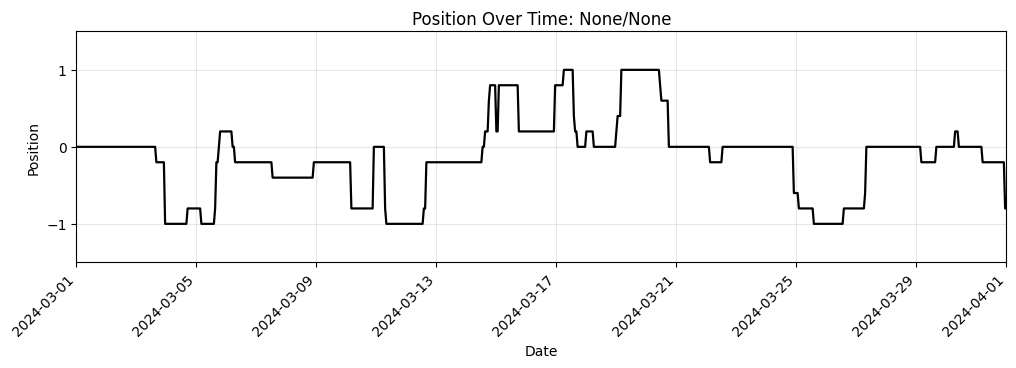

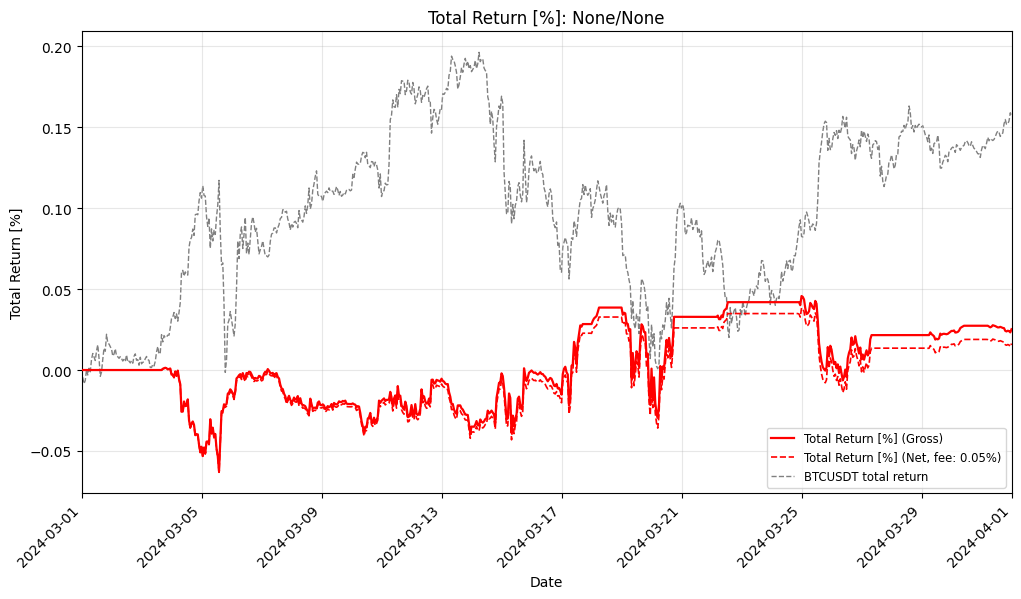

KeyError: 'z_score'

<Figure size 1200x600 with 0 Axes>

In [15]:
# Visualization
from modules.visualization.plots import plot_pnl, plot_positions, plot_zscore

plot_positions(summary, 'multi_pair_strategy', False, True)

btc_data = load_data(
    tickers=['BTCUSDT'],
    start=test_start,
    end=test_end,
    interval=interval,
)
btc_data['BTC_return'] = btc_data['BTCUSDT'].pct_change()
btc_data.loc[btc_data.index[0], 'BTC_return'] = 0.0
btc_data['BTC_cum_return'] = (1 + btc_data['BTC_return']).cumprod() - 1

plot_pnl(summary, btc_data, 'multi_pair_strategy', False, True)